In [1]:
# ---------------------------------------------------------
#                Supervised Learning
# ---------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from hazm import stopwords_list

# 1. Load Data
df = pd.read_csv('../data/processed/sentiment_data.csv')

# 2. Filter Data
# We only want to predict "Positive" vs "Negative". 
# "Neutral" comments might confuse a simple model, so we usually remove them for binary classification.
df_model = df[df['bert_label'].isin(['Positive', 'Negative'])].copy()

# 3. Encode Target
# Convert 'Positive' -> 1 and 'Negative' -> 0
df_model['target'] = df_model['bert_label'].apply(lambda x: 1 if x == 'Positive' else 0)

print("Data Prepared.")
print(f"Total Samples: {len(df_model)}")
print("Class Distribution:")
print(df_model['bert_label'].value_counts())

Data Prepared.
Total Samples: 3533
Class Distribution:
bert_label
Positive    2037
Negative    1496
Name: count, dtype: int64


In [2]:
# ---------------------------------------------------------
#    Feature Extraction (TF-IDF) & Train/Test Split
# ---------------------------------------------------------

# 1. Setup TF-IDF
# We use the same stopwords list as before to ignore "junk" words
persian_stopwords = list(stopwords_list())
# Add the extra ones we found earlier to keep it clean
extra_stops = ['آید', 'توان', 'تواند', 'توانند', 'رسد', 'رود', 'سال', 'نمی', 'های', 'گوید', 'گویند']
persian_stopwords.extend(extra_stops)

tfidf = TfidfVectorizer(
    max_features=2000,  # We only keep the top 2,000 most important words
    min_df=3,           # We ignore words that appear less than 3 times (too rare)
    stop_words=persian_stopwords
)

# 2. Define Inputs (X) and Targets (y)
X = df_model['clean_comment_text'].fillna('')
y = df_model['target']

# 3. Split Data (80% Train, 20% Test)
# random_state=42 ensures we get the same split every time we run it
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Transform Text to Numbers
# IMPORTANT: We learn the vocabulary ONLY from the Training data
X_train = tfidf.fit_transform(X_train_text)
# Then we apply that same vocabulary to the Test data
X_test = tfidf.transform(X_test_text)

print(f"Training Data Shape: {X_train.shape} (Rows, Words)")
print(f"Testing Data Shape:  {X_test.shape} (Rows, Words)")

Training Data Shape: (2826, 2000) (Rows, Words)
Testing Data Shape:  (707, 2000) (Rows, Words)



Evaluation Report:
              precision    recall  f1-score   support

    Negative       0.91      0.84      0.87       310
    Positive       0.88      0.93      0.91       397

    accuracy                           0.89       707
   macro avg       0.89      0.89      0.89       707
weighted avg       0.89      0.89      0.89       707



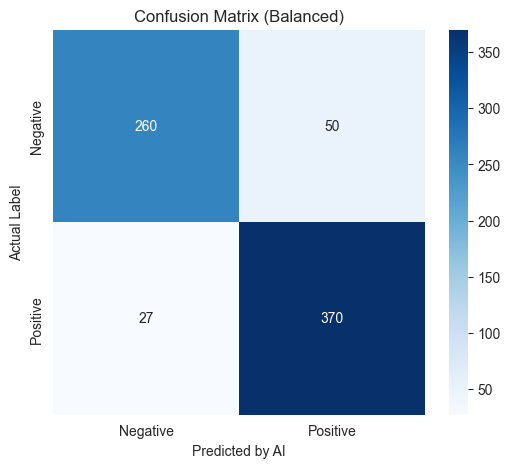

In [3]:
# ---------------------------------------------------------
#               Train Model & Evaluate
# ---------------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 1. Train the Model (with automatic balancing)
model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# 2. Predict on Test Data
# We ask the model to guess the sentiment for the 707 test comments
y_pred = model.predict(X_test)

# 3. Evaluation Report
print("\nEvaluation Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# 4. Confusion Matrix Visualization
# This shows exactly where the model made mistakes
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted by AI')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix (Balanced)')
plt.show()

C:\Users\Mohsen\AppData\Local\Temp\ipykernel_4676\2454836102.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_positive, x='Score', y='Word', ax=axes[0], palette='Greens_r')
C:\Users\Mohsen\AppData\Local\Temp\ipykernel_4676\2454836102.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels(make_farsi_readable(top_positive['Word']))  # Fix Persian labels
C:\Users\Mohsen\AppData\Local\Temp\ipykernel_4676\2454836102.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_negative, x='Score', y='Word', ax=axes[1], palette='Reds_r')
C:\Users\Mohsen\AppData\Local\Temp\ipyker

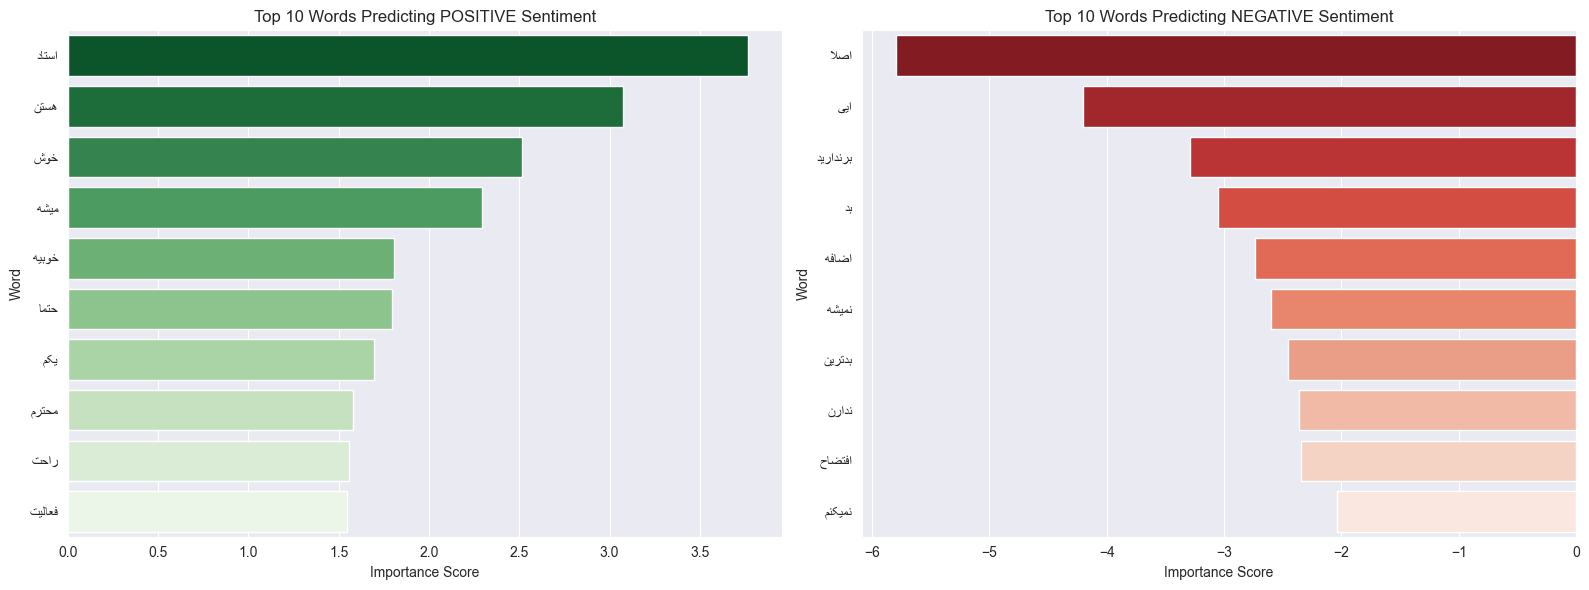

Top Positive Indicators: ['استاد' 'هستن' 'خوش' 'میشه' 'خوبیه' 'حتما' 'یکم' 'محترم' 'راحت' 'فعالیت']
Top Negative Indicators: ['اصلا' 'ایی' 'برندارید' 'بد' 'اضافه' 'نمیشه' 'بدترین' 'ندارن' 'افتضاح'
 'نمیکنم']


In [4]:
# ---------------------------------------------------------
#          Feature Importance Analysis
# ---------------------------------------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
import arabic_reshaper

# 1. Extract Feature Names (Words) & Coefficients (Weights)
feature_names = tfidf.get_feature_names_out()
coefficients = model.coef_[0]

# 2. Create a DataFrame
feature_importance = pd.DataFrame({
    'Word': feature_names,
    'Score': coefficients
})

# 3. Get Top 10 Positive & Negative Words
top_positive = feature_importance.sort_values(by='Score', ascending=False).head(10)
top_negative = feature_importance.sort_values(by='Score', ascending=True).head(10)

# 4. Function to fix Persian text for plotting
def make_farsi_readable(text_list):
    return [get_display(arabic_reshaper.reshape(w)) for w in text_list]

# 5. Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Positive
sns.barplot(data=top_positive, x='Score', y='Word', ax=axes[0], palette='Greens_r')
axes[0].set_yticklabels(make_farsi_readable(top_positive['Word']))  # Fix Persian labels
axes[0].set_title('Top 10 Words Predicting POSITIVE Sentiment')
axes[0].set_xlabel('Importance Score')

# Plot Negative
sns.barplot(data=top_negative, x='Score', y='Word', ax=axes[1], palette='Reds_r')
axes[1].set_yticklabels(make_farsi_readable(top_negative['Word']))  # Fix Persian labels
axes[1].set_title('Top 10 Words Predicting NEGATIVE Sentiment')
axes[1].set_xlabel('Importance Score')

plt.tight_layout()
plt.show()

# Print for report
print("Top Positive Indicators:", top_positive['Word'].values)
print("Top Negative Indicators:", top_negative['Word'].values)